In [2]:
import pandas as pd
import numpy as np
from xgboost.sklearn import XGBRegressor
from google.colab import drive
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, SGDRegressor, BayesianRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
import pickle

In [50]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Importing Data**

In [51]:
path_21 = '/content/drive/My Drive/Colab Notebooks/datasets/players_21.csv'
path_22 = '/content/drive/My Drive/Colab Notebooks/datasets/players_22.csv'

with open(path_21) as dataset_21, open(path_22) as dataset_22:
    fifa_21 = pd.read_csv(path_21)
    fifa_22 = pd.read_csv(path_22)

print("\nFIFA 21 Dataset Shape: " + str(fifa_21.shape))
print("FIFA 22 Dataset Shape: " + str(fifa_22.shape) + "\n")

drop = []
for col in fifa_21.columns:
    missing = (len(fifa_21[col]) - fifa_21[col].count())/len(fifa_21[col]) * 100
    if missing > 30:
        print(f'{col} = {round(missing, 2)}%')
        drop.append(col)

fifa_21.drop(columns = drop, inplace = True)
fifa_22.drop(columns = drop, inplace = True)

print("\nFIFA 21 Dataset Shape: " + str(fifa_21.shape))
print("FIFA 22 Dataset Shape: " + str(fifa_22.shape) + "\n")


FIFA 21 Dataset Shape: (18944, 110)
FIFA 22 Dataset Shape: (19239, 110)

club_loaned_from = 96.0%
nation_team_id = 94.05%
nation_position = 94.05%
nation_jersey_number = 94.05%
player_tags = 92.57%
player_traits = 56.11%
goalkeeping_speed = 89.0%
nation_logo_url = 94.05%

FIFA 21 Dataset Shape: (18944, 102)
FIFA 22 Dataset Shape: (19239, 102)



<ipython-input-51-1624cfce9c3f>:6: DtypeWarning: Columns (25,108) have mixed types. Specify dtype option on import or set low_memory=False.
  fifa_22 = pd.read_csv(path_22)


We are dropping all the columns that have more than 30% of their values missing because imputing them could create a bias.

# **Exploratory Data Analysis**

In [52]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Player Age Distribution')

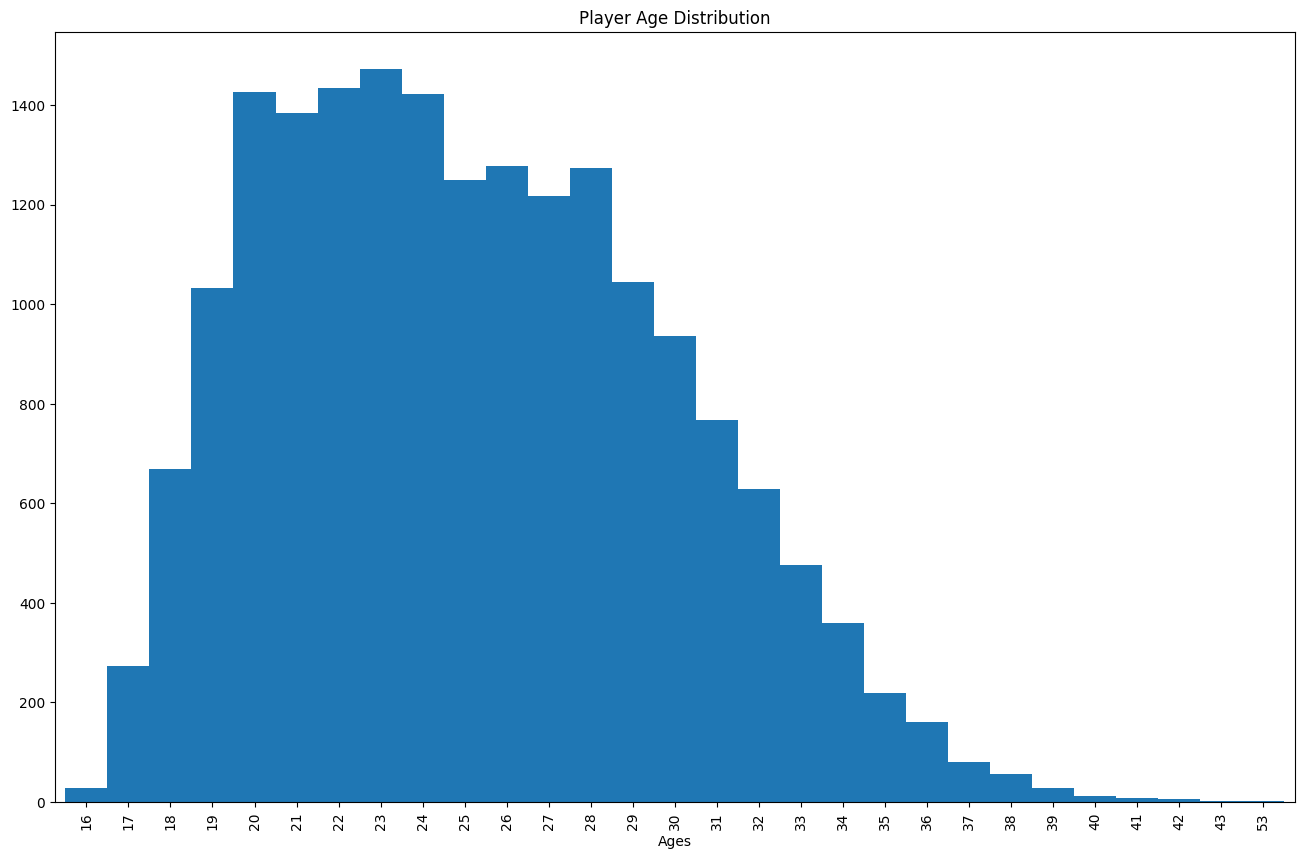

In [53]:
age = fifa_21['age']
bins=np.arange(0, 60, 1)
pd.cut(age, bins=bins, labels=bins[1:]).astype(int).value_counts().sort_index().plot.bar(width=1, figsize=(16,10))
plt.xlabel('Ages')
plt.xticks(rotation=90)
plt.title('Player Age Distribution')

<Axes: xlabel='overall', ylabel='wage_eur'>

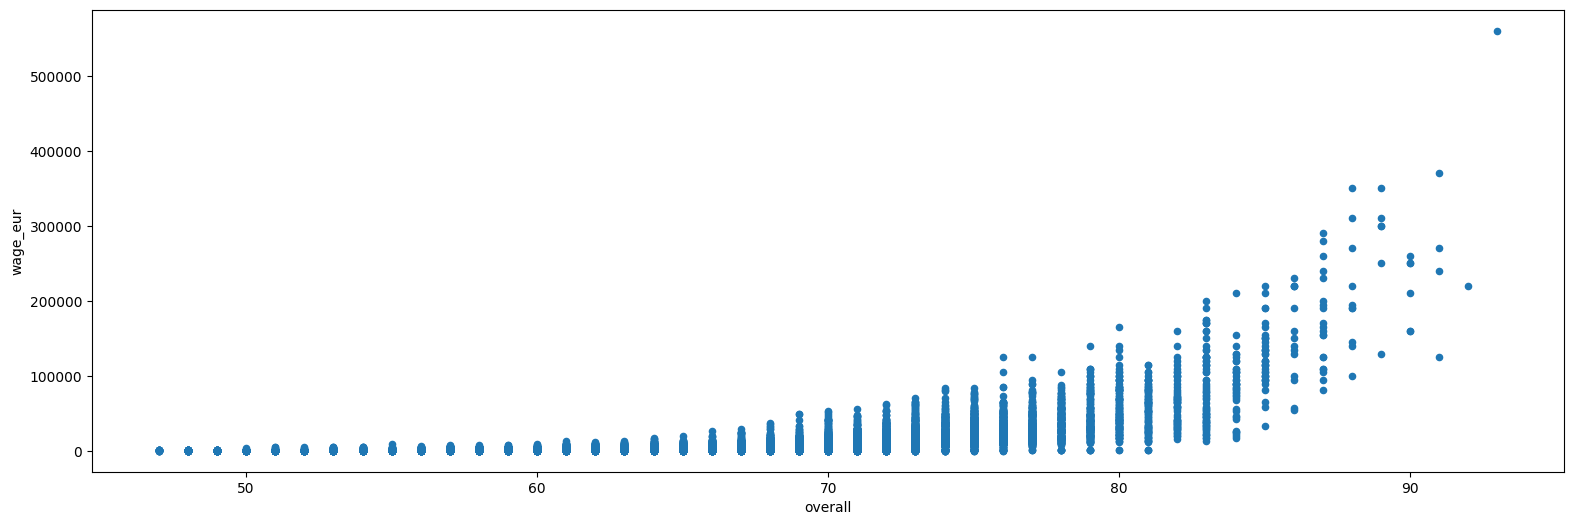

In [54]:
fifa_21.plot(kind="scatter", x="overall", y="wage_eur", figsize=(19,6))

<Axes: xlabel='overall', ylabel='value_eur'>

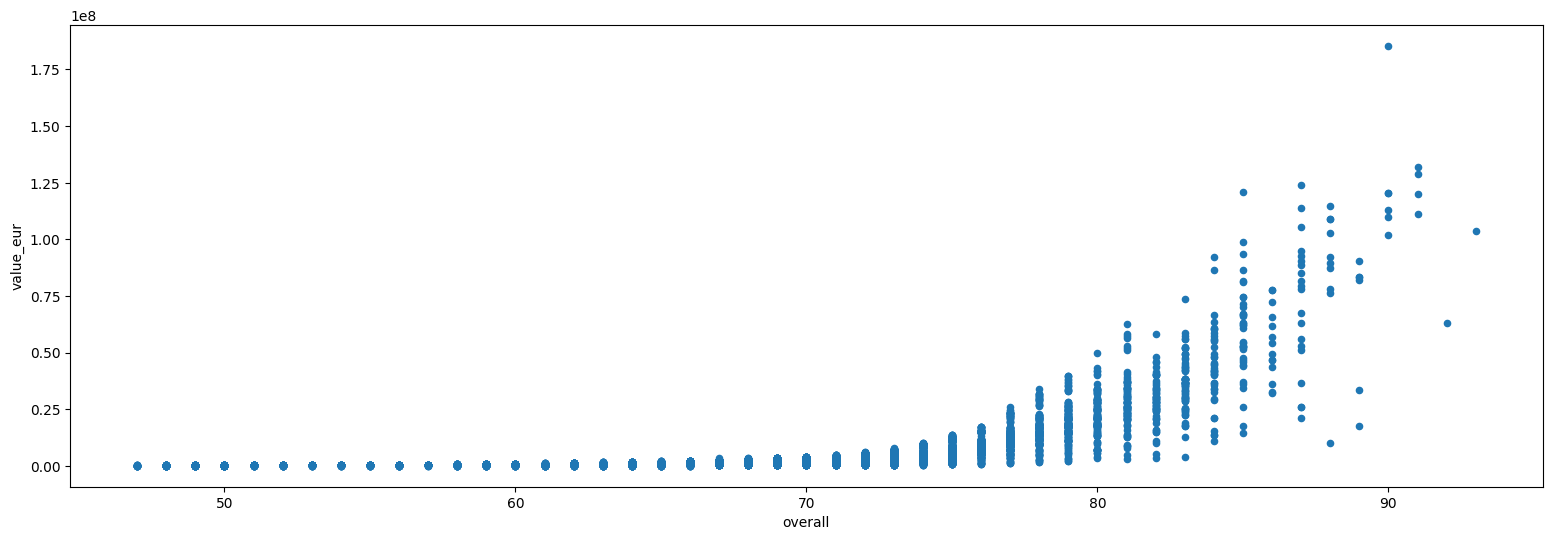

In [55]:
fifa_21.plot(kind="scatter", x="overall", y="value_eur", figsize=(19,6))

# **Subsetting Data**

In [56]:
ovr_21 = fifa_21[['overall']]
ovr_22 = fifa_22[['overall']]
correlate = fifa_21.corr()['overall'].sort_values(ascending=False)
keys = correlate.keys()
values = correlate.values
keys_to_use = []
for key,val in zip(keys, values):
    if(val>0.4): # 0.1
        keys_to_use.append(key)
keys_to_use.remove('potential')
keys_to_use.remove('release_clause_eur')
keys_to_use.remove('wage_eur')
keys_to_use.remove('value_eur')
keys_to_use.remove('international_reputation')

train_21 = fifa_21[keys_to_use]
train_22 = fifa_22[keys_to_use]
ovr_21 = train_21['overall']
ovr_22 = train_22['overall']

<ipython-input-56-85903fe85707>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlate = fifa_21.corr()['overall'].sort_values(ascending=False)


Imputation

In [57]:
imp = SimpleImputer()
imp.fit(train_21)
imputed_data=imp.fit_transform(train_21)
train_21_imp=pd.DataFrame(imputed_data, columns=train_21.columns)

imputed_data = imp.fit_transform(train_22)
train_22_imp=pd.DataFrame(imputed_data, columns=train_22.columns)

Encoding

In [58]:
categorical = ['work_rate']
labels_21 = fifa_21[categorical]
labels_22 = fifa_22[categorical]
encoder = LabelEncoder()
labels_21 = pd.DataFrame(encoder.fit_transform(labels_21), columns = labels_21.columns)
labels_22 = pd.DataFrame(encoder.fit_transform(labels_22), columns = labels_22.columns)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Scaling

In [59]:
train_21_imp.drop(columns='overall', inplace=True)
train_22_imp.drop(columns='overall', inplace=True)

In [60]:
sc = StandardScaler()
scaled = sc.fit_transform(train_21_imp)
train_21 = pd.DataFrame(scaled, columns = train_21_imp.columns)

scaled = sc.fit_transform(train_22_imp)
train_22 = pd.DataFrame(scaled, columns = train_22_imp.columns)

Randomise the arrangement of the rows in each dataframe

In [61]:
train_21 = pd.concat([train_21, ovr_21], axis = 1).sample(frac=1)
train_22 = pd.concat([train_22, ovr_22], axis = 1).sample(frac=1)

In [62]:
ovr_21 = train_21['overall']
ovr_22 = train_22['overall']
train_21.drop(columns='overall', inplace=True)
train_22.drop(columns='overall', inplace=True)

# **Model Training**

In [63]:
# imputed_data=imp.fit_transform(train_21)
# train_21=pd.DataFrame(imputed_data, columns=train_21.columns)

# imputed_data = imp.fit_transform(train_22)
# train_22=pd.DataFrame(imputed_data, columns=train_22.columns)

In [64]:
rf = RandomForestRegressor(random_state=42, n_jobs=-1)
xgb_reg = XGBRegressor(n_estimators = 1000, verbosity = 1,max_depth = 5, gamma = 0.2, subsample = 0.2, learning_rate = 0.3)
g_reg = GradientBoostingRegressor(random_state=42)
sv = SVR()
vc = VotingRegressor(estimators=[('random_forest', rf), ('xgb', g_reg), ('svm', sv)])

In [65]:
for reg in (rf, xgb_reg, g_reg, sv, vc):
    reg.fit(train_21, ovr_21)
    y_pred = reg.predict(train_21)
    mse = mean_squared_error(ovr_21, y_pred)
    mae = mean_absolute_error(ovr_21, y_pred)
    r2 = r2_score(ovr_21, y_pred)
    print(f"The {reg.__class__.__name__} model had {round(mse, 4)} MSE, {round(mae, 4)} MAE and {round(r2, 4)} R2 Score")

The RandomForestRegressor model had 0.5448 MSE, 0.5502 MAE and 0.9889 R2 Score
The XGBRegressor model had 1.1574 MSE, 0.8413 MAE and 0.9764 R2 Score
The GradientBoostingRegressor model had 4.2419 MSE, 1.5802 MAE and 0.9135 R2 Score
The SVR model had 3.3581 MSE, 1.3597 MAE and 0.9315 R2 Score
The VotingRegressor model had 2.1843 MSE, 1.1156 MAE and 0.9554 R2 Score


In [66]:
for reg in (rf, xgb_reg, g_reg, sv, vc):
    Xtrain,Xtest,Ytrain,Ytest=train_test_split(train_21,ovr_21,test_size=0.2,random_state=42)
    reg.fit(Xtrain, Ytrain)
    y_pred = reg.predict(Xtest)
    mse = mean_squared_error(y_pred, Ytest)
    mae = mean_absolute_error(y_pred, Ytest)
    r2 = r2_score(y_pred, Ytest)
    print(f"The {reg.__class__.__name__} model had {round(mse, 4)} MSE, {round(mae, 4)} MAE and {round(r2, 4)} R2 Score")

The RandomForestRegressor model had 3.8956 MSE, 1.48 MAE and 0.912 R2 Score
The XGBRegressor model had 7.2393 MSE, 2.0329 MAE and 0.8562 R2 Score
The GradientBoostingRegressor model had 4.3571 MSE, 1.5934 MAE and 0.9005 R2 Score
The SVR model had 3.5435 MSE, 1.4161 MAE and 0.9201 R2 Score
The VotingRegressor model had 3.5917 MSE, 1.4301 MAE and 0.918 R2 Score


In [67]:
for reg in (rf, xgb_reg, g_reg, sv, vc):
    y_pred = reg.predict(train_22)
    mse = mean_squared_error(ovr_22, y_pred)
    mae = mean_absolute_error(ovr_22, y_pred)
    r2 = r2_score(ovr_22, y_pred)
    print(f"The {reg.__class__.__name__} model had {round(mse, 4)} MSE, {round(mae, 4)} MAE and {round(r2, 4)} R2 Score")

The RandomForestRegressor model had 3.0871 MSE, 1.3096 MAE and 0.9348 R2 Score
The XGBRegressor model had 6.6238 MSE, 1.9399 MAE and 0.8601 R2 Score
The GradientBoostingRegressor model had 4.1793 MSE, 1.5663 MAE and 0.9117 R2 Score
The SVR model had 3.36 MSE, 1.3688 MAE and 0.929 R2 Score
The VotingRegressor model had 3.1984 MSE, 1.3509 MAE and 0.9324 R2 Score


In [68]:
from sklearn.model_selection import KFold,GridSearchCV

In [79]:
cv=KFold(n_splits=3)
param_grid = [
{'bootstrap': [True], 'n_estimators': [10, 30 ,50, 100]},
{'bootstrap': [False], 'n_estimators': [10, 30 ,50, 100]},
]
grid_search = GridSearchCV(rf, param_grid, cv=5,
scoring='neg_mean_squared_error',
return_train_score=True)
grid_search.fit(train_21, ovr_21)

GridSearchCV(cv=5, estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
             param_grid=[{'bootstrap': [True],
                          'n_estimators': [10, 30, 50, 100]},
                         {'bootstrap': [False],
                          'n_estimators': [10, 30, 50, 100]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [80]:
grid_search.best_params_

{'bootstrap': True, 'n_estimators': 100}

In [81]:
model = grid_search.best_estimator_

In [82]:
y_pred = model.predict(train_22)

In [83]:
model.score(train_22, ovr_22)

0.9393529364844386

In [84]:
mean_squared_error(ovr_22, y_pred)

2.870736337647487

In [85]:
mean_absolute_error(ovr_22, y_pred)

1.2589666822599928

In [86]:
with open('model.pkl', 'wb') as file:
    pickle.dump(model, file)

In [77]:
with open('scaler.pkl', 'wb') as file:
    pickle.dump(sc, file)

In [78]:
y_pred

array([65.78, 67.97, 64.42, ..., 61.8 , 58.1 , 65.72])